In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import pickle

In [7]:
def load_dict(filename_):
    import pickle
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

DOM_dict = load_dict("DOM_dictionary")

In [3]:
print(DOM_dict.keys())

dict_keys(['x', 'y', 'rDE', 'gain', 'TT', 'TTS', 'size', 'R', 'ix', 'iy', 'occupancy', 'SPE_res', 'TTS_c'])


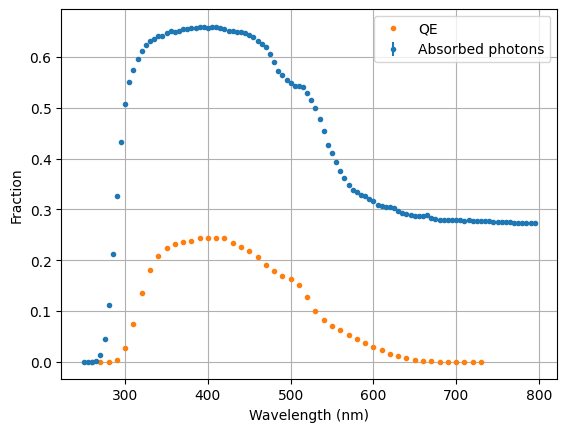

In [4]:
wvs, h,_ =np.loadtxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/build/step1.dat", unpack=1)
wvq, qe =np.loadtxt("QEDOM.data", unpack=1)
N=500000
err = np.sqrt(h) / N
h /= N
 
plt.figure()
plt.errorbar(wvs, h, fmt=".", yerr = err, label ="Absorbed photons")
plt.plot(wvq, qe, ".", label ="QE")
plt.ylabel("Fraction")
plt.xlabel("Wavelength (nm)")
plt.grid()
plt.legend()
#np.savetxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/common/data/PMTs/measurement_matching_data/QE/DOM_Hamamatsu_R7081_CT_intrinsic_QE.dat",
#           np.array([wvs, h, err]).T,
#           delimiter="\t", header="Wavelength(nm) \t QE \t error")
#np.savetxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/common/data/PMTs/measurement_matching_data/QE/DOM_Hamamatsu_R7081_mean_QE.dat",
#           np.array([wvq, qe]).T,
#           delimiter="\t",header="Wavelength(nm) \t QE")

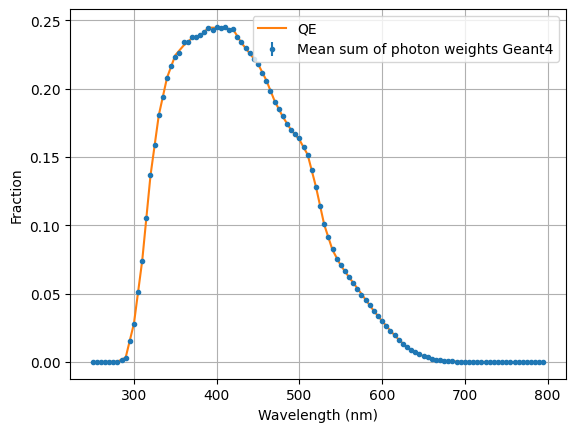

In [5]:
wvs, h, w =np.loadtxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/build/step2.dat", unpack=1)
wvq, qe =np.loadtxt("QEDOM.data", unpack=1)
N=100000
err = np.sqrt(h)*w/N**2
h /= N
w /= N
plt.figure()
plt.errorbar(wvs, w, fmt=".", yerr = err, label ="Mean sum of photon weights Geant4")
plt.plot(wvq, qe, label ="QE")
plt.ylabel("Fraction")
plt.xlabel("Wavelength (nm)")
plt.grid()
plt.legend()

In [6]:
import pandas as pd

# File path
file_path = '/HDD/fvaracar/Geant_082024/OMSim_local/OMSim_mod/new_mod/OMSim/common/data/PMTs/measurement_matching_data/setup_stuff/4inch_used_z_compensation.txt'

# Read the file using regex for whitespace separation
df = pd.read_csv(file_path, sep='\s+', header=None)

# Assign meaningful column names for easier reference
df.columns = ['r(mm)', 'z(mm)']

# Convert the 'z' column to numeric, forcing any errors to NaN
df['z(mm)'] = pd.to_numeric(df['z(mm)'], errors='coerce')

df['r(mm)'] = pd.to_numeric(df['r(mm)'], errors='coerce')
df['r(mm)'] = df['r(mm)'].round(6)
# Now apply the transformation to the "z" column
your_pmt_distance = 30
mdom_pmt_distance = 18.3

df['z(mm)'] = df['z(mm)'].iloc[-1] - df['z(mm)'] + your_pmt_distance - mdom_pmt_distance

# Round the 'z' column to 6 decimal places
df['z(mm)'] = df['z(mm)'].round(6)

# Save the modified data to a new file
#output_path = '/HDD/fvaracar/Geant_082024/OMSim_local/OMSim_mod/new_mod/OMSim/common/data/PMTs/measurement_matching_data/setup_stuff/4inch_used_z_compensation_2.txt'
#df.to_csv(output_path, sep='\t', index=False, header="r(mm) \t z(mm)",float_format='%.6f')


In [7]:
import pandas as pd

# File path
file_path = '/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/common/data/PMTs/measurement_matching_data/setup_stuff/DOM_used_z_compensation.txt'

# Read the file using regex for whitespace separation
df = pd.read_csv(file_path, sep='\s+', header=None)

# Assign meaningful column names for easier reference
df.columns = ['r(mm)', 'z(mm)']

# Convert the 'z' column to numeric, forcing any errors to NaN
df['z(mm)'] = pd.to_numeric(df['z(mm)'], errors='coerce')

df['r(mm)'] = pd.to_numeric(df['r(mm)'], errors='coerce')
df['r(mm)'] = df['r(mm)'].round(6)
# Now apply the transformation to the "z" column
your_pmt_distance = 93.3
mdom_pmt_distance = 23.8#viuslizer 18.3

df['z(mm)'] = - df['z(mm)'] + 93.3+9.5

# Round the 'z' column to 6 decimal places
df['z(mm)'] = df['z(mm)'].round(6)

# Save the modified data to a new file
#output_path = '/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/common/data/PMTs/measurement_matching_data/setup_stuff/DOMPMT_PicoQuant_Scan_Zcorrection.txt'
#df.to_csv(output_path, sep='\t', index=False, header="r(mm) \t z(mm)",float_format='%.6f')


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from iminuit import Minuit
#%matplotlib notebook

In [39]:
def find_nearest(array, value):
    """Find the nearest value in an array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def initialize_dicts(Rs, Rbins):
    """Initialize the dictionary structure."""
    dicts = {}
    for r in Rs:
        dicts[r] = {
            "hist": np.zeros(Rbins.size - 1),
            "hist_weighted": np.zeros(Rbins.size - 1),
            "counts": 0,
            "total": 0,
            "total_weighted": 0
        }
    return dicts

def process_data(data, dicts, Rs, N = 10000):
    """Process the input data and update the dictionaries."""
    for line in data:
        x, y = line[0], line[1]
        h = line[2:]
        sz = int(h.size / 2)
        Rfile = np.sqrt(x**2 + y**2)
        nearest_R = find_nearest(Rs, Rfile)
        
        dicts[nearest_R]["hist"] += h[:sz]
        dicts[nearest_R]["hist_weighted"] += h[sz:]
        dicts[nearest_R]["counts"] += 1
        dicts[nearest_R]["total"] += np.sum(h[:sz])
        dicts[nearest_R]["total_weighted"] += np.sum(h[sz:])
    
    return dicts, N

def normalize_histograms(dicts, N):
    """Normalize the histograms in the dictionaries."""
    for key in dicts:
        counts = dicts[key]["counts"] + 1e-9  # Avoid division by zero
        dicts[key]["norm_hist"] = dicts[key]["hist"] / counts / N
        dicts[key]["norm_hist_weighted"] = dicts[key]["hist_weighted"] / counts / N
        dicts[key]["norm_hist_err"] = np.sqrt(dicts[key]["total"]) / counts / N
        dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]
    return dicts

In [49]:

# Parameters
Rs = np.arange(0, 127.75, 0.75)  # Binning of R_A
step = 0.75
Rbins = np.arange(0, 127.75, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])



# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/build/step3.dat")
#data = np.loadtxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/build/step3_after.dat")
dicts, N = process_data(data, dicts, Rs)

# Normalize histograms
dicts = normalize_histograms(dicts, N)
dicts["R_beam_position"] = Rs
dicts["R_absorbed_position"] = Rbins_x

/tmp/ipykernel_753100/3611166848.py:44: RuntimeWarning: invalid value encountered in divide
  dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]


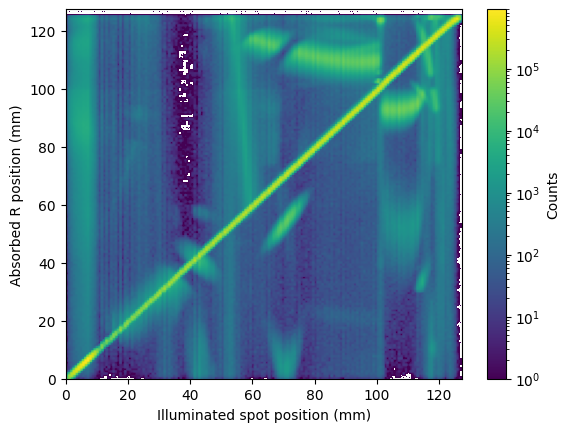

In [50]:
matrix = []
for r in Rs:
    matrix.append(dicts[r]["hist"])
matrix = np.array(matrix)

plt.figure()
im = plt.imshow(matrix.T, aspect="auto", origin="lower", norm=LogNorm(), extent= (Rs[0], Rs[-1], Rbins[0], Rbins[-1]))
plt.colorbar(im, label='Counts')
plt.xlabel("Illuminated spot position (mm)")
plt.ylabel("Absorbed R position (mm)")
plt.show()

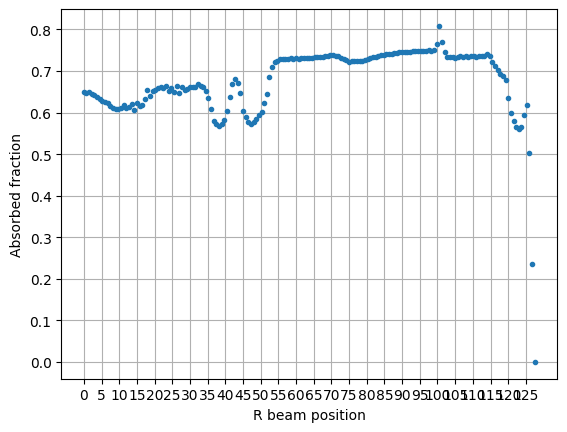

0.75


In [51]:
# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = [dicts[r]["total"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p]
e_p = [dicts[r]["norm_hist_err"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p, yerr=e_p, fmt='.')
plt.grid(True)
plt.xticks(np.arange(round(min(r_p)), round(max(r_p)), 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()
print(r_p[1]-r_p[0])

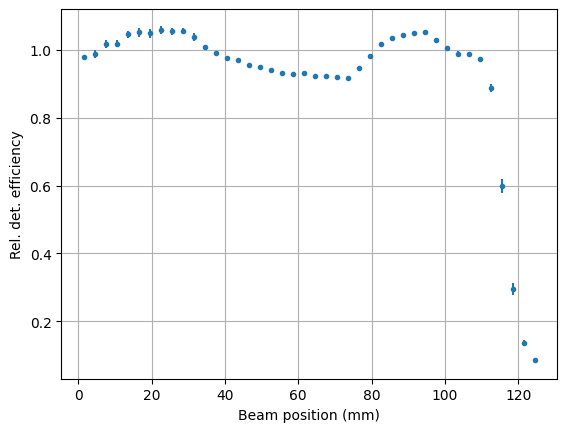

In [52]:
'''
The data was prepared from the measurement of 5 PMTs. 
The rel. detection efficiency scan was reduced to a profile, binning the scan by R. 
The binning started at R=1.5mm, since there are not enough data points at centre. The data at R<1.5 mm was averaged
and assigned to x=0.
x: is the central position of bin,(except for x=0)
y: average rel. det. efficiency 
y_err: std error between different pmts
step: Step of binning

y values were normalised with average detection efficiency in central region (R<25)
'''
def bin_data(x, y, bin_width):
    assert len(x) == len(y), f"Arrays x and y must be of the same length but they are not with len(x)={len(x)} and len(y)={len(y)}"
    x = np.array(x)
    y = np.array(y)
    new_x = np.arange(0, round(max(x)), bin_width)  # Define the bin positions
    new_y = []
    new_y_err = []

    for i in range(len(new_x)-1):
        prov_y = []
        # Get the indices of values within the bin range
        indices_in_bin = (x > new_x[i]) & (x <= new_x[i+1]) if i > 0 else (x <= new_x[i+1])
        # Filter the y values corresponding to the current bin
        prov_y = y[indices_in_bin]
        
        # Calculate the mean for the bin
        if len(prov_y) > 0 and prov_y.any():
            new_y.append(np.mean(prov_y))
            new_y_err.append(np.std(prov_y)/np.sqrt(len(prov_y)) if len(prov_y) > 1 else 0)
        else:
            raise ValueError()
            new_y.append(np.nan)  # No data points in this bin
            new_y_err.append(np.nan)
    
    new_y = np.array(new_y)
    new_y_err = np.array(new_y_err)
    x2 = 0.5*(new_x[:-1]+new_x[1:])
    new_x = new_x[:-1]
    norm = np.mean(new_y[new_x<60])
    return x2, new_y/norm, new_y_err/norm  


step=3
#(x, y, y_err, step) = np.load("mDOM_relDetEfficiency.npy", allow_pickle=1)
DOM_dict = load_dict("DOM_dictionary")

x = DOM_dict["R"]
y = DOM_dict["rDE"]
new_x,new_y,err_y = bin_data(x,y,bin_width=step)
plt.figure()
plt.errorbar(new_x,new_y,yerr=err_y, fmt = ".")
plt.ylabel("Rel. det. efficiency")
plt.xlabel("Beam position (mm)")

#initial_model_output = fit_handling.model(p0)

#plt.plot(fit_handling.x_data, initial_model_output, label='Initial Model Output', linestyle='--', color='blue')
plt.grid()


# Fitting

In [53]:
print(max(new_x))

124.5


In [54]:
fit_handling = Fit(new_x, step, new_y, err_y, dicts, np.arange(0, 125, 1))

In [55]:
#First leave the central CE weights = 1
initial = {}
limits = {}
fix = {}
names = list()
p0 = []

for i,bins in enumerate(fit_handling.r_weights[:-1]):
    names.append("w_"+str(i))
    initial[names[-1]] = 0.0
    p0.append(0.0)
    if bins<20:
        limits[names[-1]] = (-0.2, 0.2)
    else:
        limits[names[-1]] = (-0.1, 0.2)
        
    if bins<5:
        fix[names[-1]] = False#True
    else:
        fix[names[-1]] = False

In [56]:
print(len(np.arange(0, max(new_x),step)))
print(len(new_y))
print(len(new_x))
print(len(err_y))

42
42
42
42


In [57]:
import numpy as np
from scipy.interpolate import interp1d

class Fit:
    def __init__(self, x, x_step, y, y_err, simu_data, r_weights):
        """
        Initialize the Fit class with data and simulation parameters.

        :param x: x-axis data points
        :param y: y-axis data points
        :param y_err: errors on y-axis data points
        :param simu_data: simulation data dictionary
        :param r_weights: r position of fitted weight values
        """
        self.x_data = x
        self.x_step = x_step
        self.y_data = y
        self.y_err_data = y_err
        self.simu_data = simu_data
        self.r_weights = r_weights
        self.y_err_sim = self.estimate_simulation_error()

    def estimate_simulation_error(self):
        """Estimate simulation error using interpolation."""
        e_p = [self.simu_data[r]["norm_hist_err"] for r in self.simu_data["R_beam_position"]]
        f = interp1d(self.simu_data["R_beam_position"], e_p, fill_value="extrapolate")
        return f(self.x_data)

    def trafo(self, fit_parameters):
        """
        Transform fitted parameters into CE weights.

        :param input_weights: fit parameters
        :return: Cumulative weights
        """
        weights = [1]  # at R=0 we assume CE = 1
        for diff in fit_parameters:
            new_weight = max(weights[-1] - diff, 0)
            weights.append(new_weight)
        return np.array(weights)

    def model(self, weights):
        weights = self.trafo(weights)  # Convert to cumulative weights
        f = interp1d(self.r_weights, weights, kind="slinear", fill_value=0, bounds_error=False)
        weights_detailed = f(self.simu_data["R_absorbed_position"])

        # Weight all histograms with CE weights
        weighted_histograms = [np.nansum(self.simu_data[r]["norm_hist"] * weights_detailed) 
                for r in self.simu_data["R_beam_position"]]
        weighted_histograms = np.array(weighted_histograms)

        # Calculate rel. DE values for each r position
        y = [self._calculate_y_value(weighted_histograms, i) for i in range(len(self.x_data))]
        y = np.array(y)

        # Normalize the output
        norm = np.mean(y[y > 0][self.x_data[y > 0] < 60])
        return y / norm

    def _calculate_y_value(self, weighted_histograms, index):
        #if index == 0:
        #    mask = self.simu_data["R_beam_position"] < self.x_data[1]-self.x_step*0.5
        #    return np.nanmean(weighted_histograms[mask])
        if True:
            mask = np.logical_and(self.simu_data["R_beam_position"] < self.x_data[index]+self.x_step*0.5,
                                  self.simu_data["R_beam_position"] >= self.x_data[index]-self.x_step*0.5)
            return np.nanmean(weighted_histograms[mask])

    def chi(self, *args):
        """
        Calculate chi-squared value for the model.

        :param args: Weight differences to be passed to the model
        :return: Chi-squared value
        """
        mdl = self.model(args)
        mask = np.logical_and(mdl > 0, self.x_data > 2)
        #print(mask,len(mask))
        #print(f"Length of mdl: {len(mdl)}")
        #print(f"Length of x_data: {len(self.x_data)}")
        #print(f"Length of y_data: {len(self.y_data)}")
        #print(f"Length of y_err_sim: {len(self.y_err_sim)}")
        #print(self.y_data[mask])
        return np.sum((self.y_data[mask] - mdl[mask]) ** 2 / self.y_err_sim[mask] ** 2)

In [58]:
m = Minuit(fit_handling.chi, *p0, name=names)

for key, val in limits.items():
    m.limits[key] = val
    
for key, val in fix.items():
    m.fixed[key] = val
    
m.strategy = 1
m.errordef = 1
fit_handling.chi(*p0) #Check that chi is working

np.float64(5147263.392606602)

In [59]:
#run fit
m.migrad(ncall = 500000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.003284                   │             Nfcn = 46407             │
│ EDM = 0.000119 (Goal: 0.0002)    │           time = 128.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌────┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│    │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├────┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0  │ w_0   │ 1.2011e-1 │ 0.0000e-1 │            │            │  -0.2   │   0.2   │       │
│ 1  │ w_1   │ 5.1267e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 2  │ w_2   │-1.9641e-1 │ 0.0000e-1 │            │            │  -0.2   │   0.2   │       │
│ 3  │ w_3   │ 1.9998e-1 │ 0.0000e-1 │            │            │  -0.2   │   0.2   │       │
│ 4  │ w_4   │-1.4449e-1 │ 0.0000e-1 │            │            │  -0.2   │   0.2   │       │
│ 5  │ w_5   │-3.8183e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 6  │ w_6   │ 2.8678e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 7  │ w_7   │ 7.3925e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 8  │ w_8   │-8.7012e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 9  │ w_9   │-1.1518e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 10 │ w_10  │-1.0901e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 11 │ w_11  │-1.0316e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 12 │ w_12  │-7.6272e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 13 │ w_13  │-1.8804e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 14 │ w_14  │ 4.2977e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 15 │ w_15  │ 1.3118e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 16 │ w_16  │ 2.4347e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 17 │ w_17  │ 2.7647e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 18 │ w_18  │ 1.7084e-2 │ 0.0000e-2 │            │            │  -0.2   │   0.2   │       │
│ 19 │ w_19  │ 2.7578e-3 │ 0.0000e-3 │            │            │  -0.2   │   0.2   │       │
│ 20 │ w_20  │-9.7484e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 21 │ w_21  │-7.1726e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 22 │ w_22  │-2.8111e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 23 │ w_23  │-9.9539e-4 │ 0.0000e-4 │            │            │  -0.1   │   0.2   │       │
│ 24 │ w_24  │ 1.3997e-4 │ 0.0000e-4 │            │            │  -0.1   │   0.2   │       │
│ 25 │ w_25  │ 6.7587e-4 │ 0.0000e-4 │            │            │  -0.1   │   0.2   │       │
│ 26 │ w_26  │ 1.4858e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 27 │ w_27  │ 4.5692e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 28 │ w_28  │ 8.0623e-3 │ 0.0000e-3 │            │            │  -0.1   │   0.2   │       │
│ 29 │ w_29  │ 1.1987e-2 │ 0.0000e-2 │            │            │  -0.1   │   0.2   │       │
│ 30 │ w_30  │ 1.78

Text(0, 0.5, 'Relative detection efficiency')

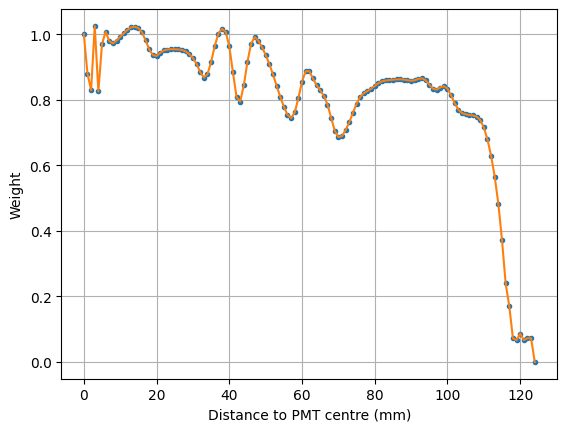

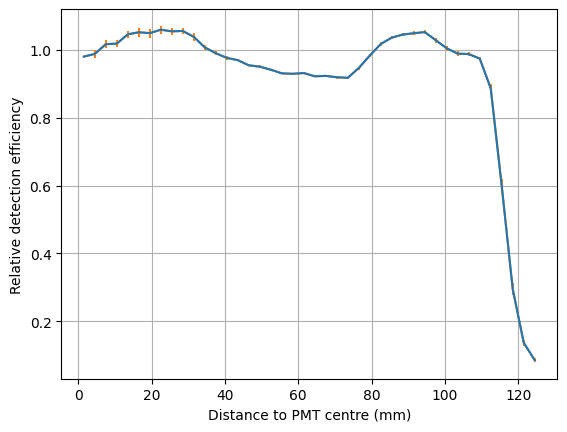

In [60]:
#Check current output
plt.figure()

plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values), yerr = np.append(0,m.errors), fmt =  '.')
plt.errorbar(fit_handling.r_weights,y=fit_handling.trafo(m.values))
plt.grid()
plt.ylabel("Weight")
plt.xlabel("Distance to PMT centre (mm)")
#plt.ylim(0,1.2)


plt.figure()
mdl = fit_handling.model(m.values)
plt.plot(fit_handling.x_data, mdl, zorder = 100)
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
#plt.ylim(0,1.2)
plt.grid()
plt.xlabel("Distance to PMT centre (mm)")
plt.ylabel("Relative detection efficiency")

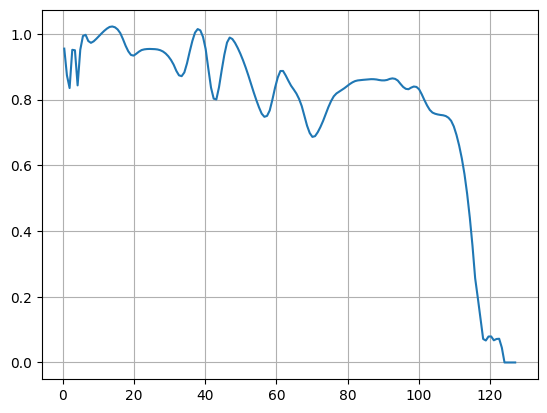

In [61]:
#Save weights
fl = interp1d(fit_handling.r_weights, fit_handling.trafo(m.values), kind = "slinear", fill_value=0, bounds_error=False) 
weights_detailed = fl(fit_handling.simu_data["R_absorbed_position"])
plt.figure()
plt.plot(fit_handling.simu_data["R_absorbed_position"], weights_detailed)
plt.grid()

with open("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/common/data/PMTs/measurement_matching_data/CE_weight/241011_PDOM.dat", "w") as f:
    f.write(f"#R(mm) Weight \n")
    f.write(f"{0}\t{fl(0)}\n")
    for r, weight in zip(fit_handling.simu_data["R_absorbed_position"], weights_detailed):
        f.write(f"{r}\t{weight}\n")

/tmp/ipykernel_753100/3611166848.py:44: RuntimeWarning: invalid value encountered in divide
  dicts[key]["norm_hist_err_weighted"] = dicts[key]["norm_hist_err"]*dicts[key]["norm_hist_weighted"]/dicts[key]["norm_hist"]


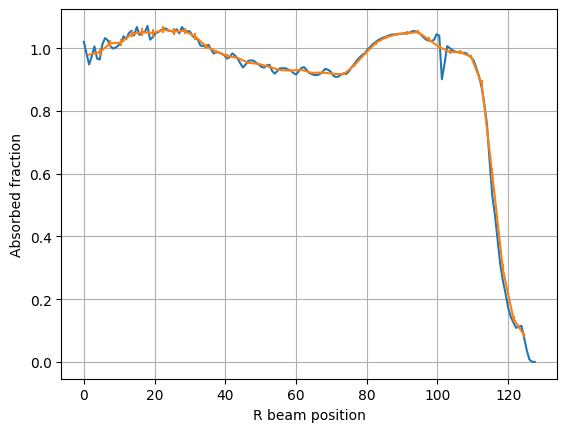

In [68]:
# Parameters
#Rs = np.arange(0, 41.25, 0.25)  # Binning of R_A
#step = 0.25
#Rbins = np.arange(0, 41.25, step)  # Binning of simulation output 
#Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])


# Parameters
Rs = np.arange(0, 127.75, 0.75)  # Binning of R_A
step = 0.75
Rbins = np.arange(0, 127.75, step)  # Binning of simulation output 
Rbins_x = 0.5 * (Rbins[:-1] + Rbins[1:])



# Initialize dictionaries
dicts = initialize_dicts(Rs, Rbins)

# Load and process data
data = np.loadtxt("/HDD/fvaracar/Geant_082024/OMSim_local/OMSim/OMSim/build/step3_after.dat")
dicts, N = process_data(data, dicts, Rs, 1000)

# Normalize histograms
dicts = normalize_histograms(dicts, N)

# Plot mean absorbed fraction of photons vs R
r_p = Rs
h_p = np.array([dicts[r]["total_weighted"] / (dicts[r]["counts"] + 1e-9) / N for r in r_p])
e_p = [dicts[r]["norm_hist_err_weighted"] for r in r_p]

plt.figure()
plt.errorbar(r_p, h_p/np.mean(h_p[r_p<60]))#, yerr = e_p, fmt='.')
plt.errorbar(fit_handling.x_data,fit_handling.y_data, yerr=fit_handling.y_err_data, zorder = 10)
plt.grid(True)
#plt.xticks(np.arange(0, 45, 5))
plt.xlabel("R beam position")
plt.ylabel("Absorbed fraction")
plt.show()